
Python was not able to load the fast fortran material routines.


*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_square.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_square.msh successfully imported. 
Assign a material to a physical group.
*************************************************************


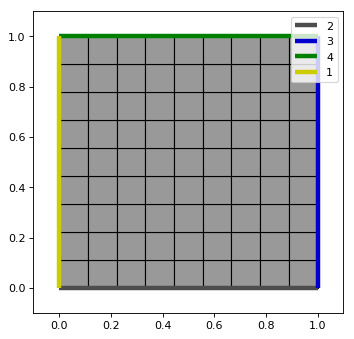

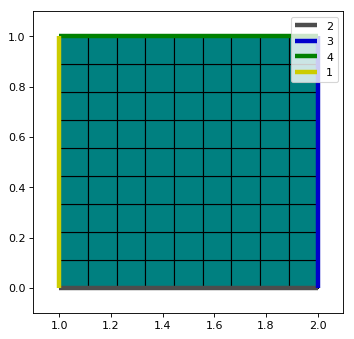

In [1]:
# importaint libraries
import sys 
import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# mesh files to be imported
msh_dict = {}
msh_dict[1] =  amfe.amfe_dir('meshes/test_meshes/1_square.msh')


# id of physical domain
domain_id = {}
domain_id[1] = 6


# importing mesh 1
m1 = amfe.Mesh()
m1.import_msh(msh_dict[1])

m2 = m1.translation([1,0,0])

fig, ax1=plt.subplots(1,figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_mesh(m1,ax1)

fig, ax2=plt.subplots(1,figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_mesh(m2,ax2)



plt.show()


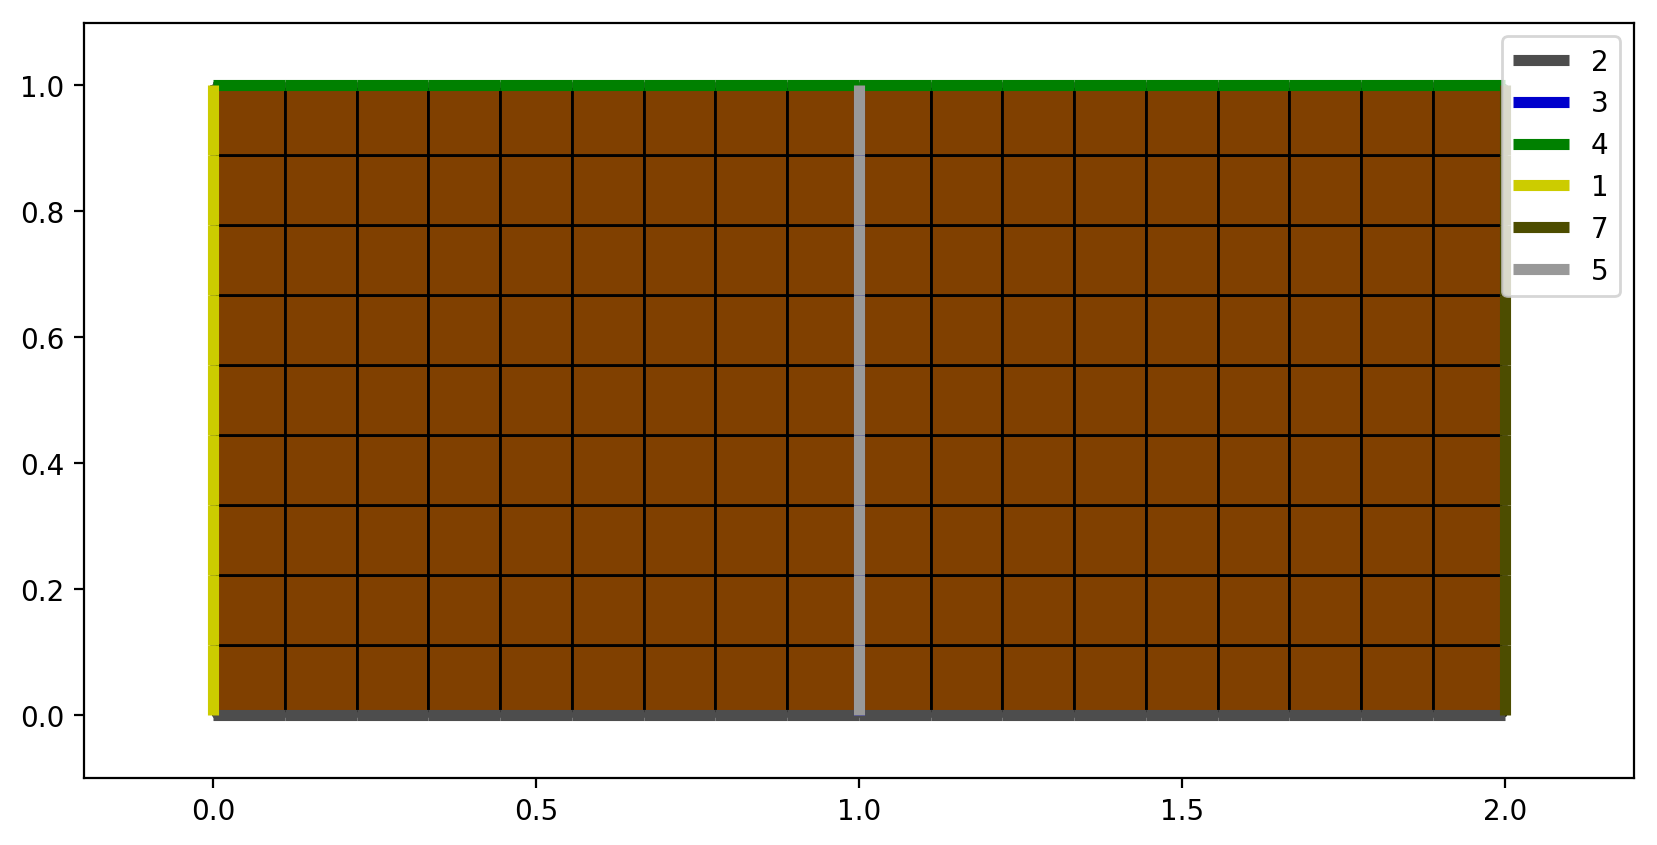

In [2]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

# append domains to MechanicalAssembly
my_system = amfe.MechanicalAssembly()

submesh1 = m1.set_domain('phys_group',domain_id[1])
submesh2 = m2.set_domain('phys_group',domain_id[1])

my_system.append_domain(submesh1, my_material, 1)
my_system.append_domain(submesh2, my_material, 2)
my_system.update_global_system()

# replacing phys tags to avoid conflict
my_system.change_domain_physical_tag(2,1,5)
my_system.change_domain_physical_tag(2,3,7)
my_system.update_global_system() 

# select submesh for interfaces
sub_int1 = my_system.get_submesh(1,3)
sub_int2 = my_system.get_submesh(2,5)
my_system.add_bonded_interface_constraint(sub_int1,sub_int2)
my_system.update_global_system() 
   

# mesh of one turbine section
new_mesh = my_system.get_global_mesh()

fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
amfe.plot_mesh(new_mesh,ax1)
plt.show()

In [3]:
global_system = my_system

# select submesh for Neumann B.C
sub_neu1 = global_system.get_submesh(2,7)

# select submesh for Dirichlet
sub_dir1 = global_system.get_submesh(1,1)

value = 1.0e8
global_system.apply_neumann_boundaries(sub_neu1,value)
global_system.apply_dirichlet_boundaries(sub_dir1,0.0,'xy')

global_system.update_domain()
domain = global_system
domain.split_in_partitions()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 162 elements and 380 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 324 elements and 380 dofs.
Time taken for preallocation: 0.01 seconds.
Extract interface node from sub_1 and sub_2
Interface nodes from sub_2 and sub_1 already extracted
Extract interface node from sub_1 and sub_2
Interface nodes from sub_2 and sub_1 already extracted


{1: <amfe.mesh.SubMesh at 0x164470c4400>,
 2: <amfe.mesh.SubMesh at 0x164470b3ac8>}

In [4]:
super_domain = amfe.SuperDomain(domain.groups)
B = super_domain.assemble_global_B()
Kd, fd = super_domain.assemble_block_stiffness_and_force()
G, e = super_domain.assemble_global_G_and_e()
F, d = super_domain.assemble_F_and_d()

n_null = len(e) # null space size
n_int = len(d) # interface size
Zeros = np.zeros([n_null ,n_null])

A1 = np.hstack((F,G.T))
A2 = np.hstack((G,Zeros))

A = np.vstack((A1,A2))
b = np.concatenate((d,e))

# Dual interface problem
x = np.linalg.solve(A,b)
global_lambda = x[:n_int]
alpha = x[n_int:]

global_alpha = alpha

u = super_domain.eval_subdomain_displacement(global_lambda,alpha)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 81 elements and 200 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 81 elements and 200 dofs.
Time taken for preallocation: 0.00 seconds.


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\Lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def plot_static(scale=0):
    connectivity = {}
    nodes = {}
    ax = plt.axes()
    for sub_key in super_domain.domains_key_list:
        sub = super_domain.get_feti_subdomains(sub_key)
        connectivity[sub_key] = sub.mesh.connectivity
        nodes[sub_key] = sub.mesh.nodes
        quad, ax = amfe.plotDeformQuadMesh(connectivity[sub_key],nodes[sub_key],u[sub_key],scale,ax) 
          
    plt.show()

interact(plot_static,scale=(0,1000,5))  

A Jupyter Widget

<function __main__.plot_static>

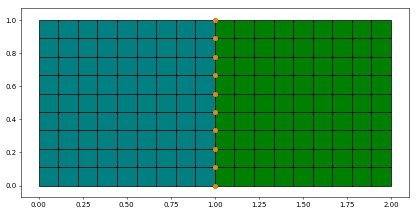

In [6]:
fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 50, facecolor='w', edgecolor='k')
amfe.plot_domain(domain,ax1)
plt.show()

In [7]:
super_domain.lambda_global_dict

{(1,
  2): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 (2,
  1): array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19])}

In [8]:
sub1 = super_domain.get_feti_subdomains(1)
sub2 = super_domain.get_feti_subdomains(2)

In [9]:
sub1.global_interface_nodes_dict

{2: [3, 2, 12, 13, 14, 15, 16, 17, 18, 19]}

In [10]:
sub1.local_interface_nodes_dict

{2: [90, 99, 91, 92, 93, 94, 95, 96, 97, 98]}

In [11]:
sub2.local_interface_nodes_dict

{1: [0, 19, 3, 5, 7, 9, 11, 13, 15, 17]}

In [12]:
sub1.id_matrix[0]

[0, 1]

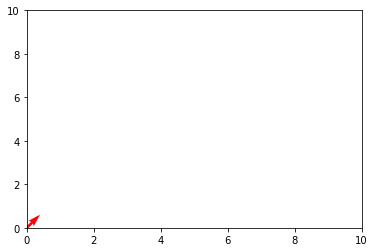

In [13]:
plt.quiver([0.0],[0.0],[1],[1], color=['r'])
plt.xlim([0,10])
plt.ylim([0,10])
plt.show()

In [14]:
coord = []
for nei in sub1.local_interface_nodes_dict:
    for node in sub1.local_interface_nodes_dict[nei]:
        coord.append(sub1.submesh.local_node_list[node])

In [15]:
global_lambda

array([ -5.52410184e+06,   8.51522253e+03,  -5.52410184e+06,
        -8.51522253e+03,  -1.10667361e+07,   3.21073610e+04,
        -1.11045225e+07,   4.43705221e+04,  -1.11413702e+07,
         3.60839840e+04,  -1.11632694e+07,   1.36776337e+04,
        -1.11632694e+07,  -1.36776337e+04,  -1.11413702e+07,
        -3.60839840e+04,  -1.11045225e+07,  -4.43705221e+04,
        -1.10667361e+07,  -3.21073610e+04])

In [16]:
l = global_lambda.reshape((10, 2))

In [17]:
global_lambda

array([ -5.52410184e+06,   8.51522253e+03,  -5.52410184e+06,
        -8.51522253e+03,  -1.10667361e+07,   3.21073610e+04,
        -1.11045225e+07,   4.43705221e+04,  -1.11413702e+07,
         3.60839840e+04,  -1.11632694e+07,   1.36776337e+04,
        -1.11632694e+07,  -1.36776337e+04,  -1.11413702e+07,
        -3.60839840e+04,  -1.11045225e+07,  -4.43705221e+04,
        -1.10667361e+07,  -3.21073610e+04])

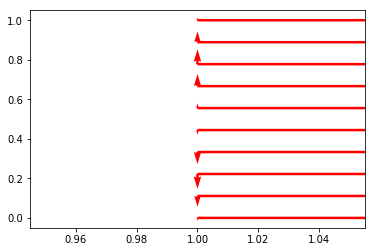

In [18]:
x = []
y = []
s = 1000000
for i in range(10):
    x.append(-l[i,0])
    y.append(-l[i,1])
    plt.quiver(coord[i][0],coord[i][1],-l[i,0],0, color=['r'],scale=s)
    plt.quiver(coord[i][0],coord[i][1],0,-l[i,1], color=['r'],scale=s)
plt.show()

In [19]:
l = sub1.local_interface_nodes_dict[2]
k = np.argsort(np.array(l))
print(k)

print(l)

[0 2 3 4 5 6 7 8 9 1]
[90, 99, 91, 92, 93, 94, 95, 96, 97, 98]


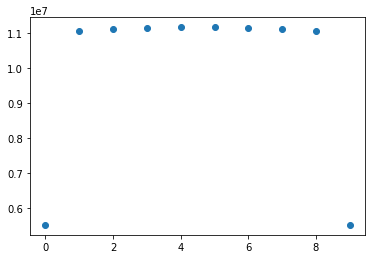

In [24]:
plt.plot(np.array(x)[k],'o')
plt.show()

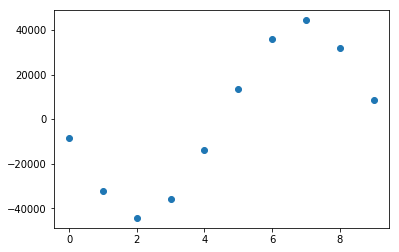

In [25]:
plt.plot(np.array(y)[k],'o')
plt.show()

In [22]:
x

[5524101.8393667517,
 5524101.8393915305,
 11066736.100903161,
 11104522.483687799,
 11141370.220056998,
 11163269.355868062,
 11163269.355899455,
 11141370.220119674,
 11104522.483749487,
 11066736.10095783]